In [1]:
import numpy as np
import matplotlib.pyplot as plt

import subprocess
import os
import json

In [19]:
e2e_folder = "../../../../test/e2e/"
output_folder = "./csv/"
img_folder = "./imgs/"

In [3]:
test_states = 8
iterations = 2

timeout = 300

json_stats = dict()

for n_states in range(1, test_states + 1):
    print(f"---- Starting test of n_states {n_states} ----")

    json_stats[n_states] = []

    with open(f"{e2e_folder}networks/epoch.toml", "r") as src:
        with open(f"{e2e_folder}/networks/simple_modified.toml", "w") as dst:
            for l in src:
                if l.startswith("n_states"):
                    dst.write(f"n_states = {n_states}\n")
                else:
                    dst.write(l)
    
    with open(f"{output_folder}/benchmark.txt", "w") as f:
        f.write("")
    
    success = 0
    for i in range(iterations):
        try:
            subprocess.run([f"{e2e_folder}/build/runner", "-f", f"{e2e_folder}/networks/simple_modified.toml", "benchmark"], timeout=timeout)
            success += 1
        except:
            print(f"Timing out after {timeout}s")
            if success == 0 and i == iterations - 1:
                i -= 1

    with open(f"{output_folder}/benchmark.txt", "r") as f:
        for l in f:
            json_stats[n_states].append(l)

    print("Updated json_stats")
    print(json_stats)

with open(f"{output_folder}/benchmark_total.txt", "w") as f:
    f.write(json.dumps(json_stats))

---- Starting test of n_states 1 ----
I[2025-08-24|07:19:12.613] Removing Docker containers and networks      
I[2025-08-24|07:19:12.799] cleanup dir                                  msg="Removing testnet directory `../../../../test/e2e//networks/simple_modified`"
I[2025-08-24|07:19:13.084] setup                                        msg="Generating testnet files in `../../../../test/e2e//networks/simple_modified`"
I[2025-08-24|07:19:13.104] Starting initial network nodes...            
I[2025-08-24|07:19:13.104] load                                         msg="Starting transaction load (16 workers)..."
E[2025-08-24|07:19:13.110] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5710/v1\": dial tcp 127.0.0.1:5710: connect: connection refused"
E[2025-08-24|07:19:13.110] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5704/v1\": dial tcp 127.0.0.1:5704: connect: connection refused"
D[2025-08-24|07:19:13.1

In [16]:
with open(f"{output_folder}/benchmark_total.txt", "r") as f:
    json_stats = json.load(f)
print("Last json_stats")
print(json_stats)

Last json_stats
{'1': ['{"blocks":99,"case":"simple_modified.toml","dur":137.442004166,"end_height":106,"max":1.541667334,"mean":1.377066792,"min":1.263843834,"size":4,"start_height":7,"stddev":0.048417018409993226,"txns":276}\n', '{"blocks":99,"case":"simple_modified.toml","dur":138.451933083,"end_height":106,"max":1.502922584,"mean":1.383484867,"min":1.2764260840000001,"size":4,"start_height":7,"stddev":0.04999488330480477,"txns":277}\n'], '2': ['{"blocks":99,"case":"simple_modified.toml","dur":136.469662,"end_height":106,"max":1.478683084,"mean":1.365590463,"min":1.259349501,"size":4,"start_height":7,"stddev":0.04197149964159323,"txns":274}\n', '{"blocks":99,"case":"simple_modified.toml","dur":138.39527,"end_height":106,"max":1.481969751,"mean":1.383157356,"min":1.281895459,"size":4,"start_height":7,"stddev":0.042221231570474596,"txns":276}\n'], '3': ['{"blocks":99,"case":"simple_modified.toml","dur":137.108754042,"end_height":106,"max":1.482323292,"mean":1.369120725,"min":1.3004002

In [20]:
mean_times = dict()
max_times = dict()
min_times = dict()

for n_states, stats in json_stats.items():
    mean_times[n_states] = 0
    max_times[n_states] = -1000
    min_times[n_states] = 1000

    for json_stat in stats:
        stat = json.loads(json_stat)
        mean_times[n_states] += stat["mean"]
        max_times[n_states] = max(max_times[n_states], stat["max"])
        min_times[n_states] = min(min_times[n_states], stat["min"])
    mean_times[n_states] /= len(stats)

print(f"Stats for all {len(mean_times)} tests")
for n_states in mean_times:
    print(f"Stats for {n_states}: Mean {mean_times[n_states]} max {max_times[n_states]} min {min_times[n_states]}")

Stats for all 8 tests
Stats for 1: Mean 1.3802758295 max 1.541667334 min 1.263843834
Stats for 2: Mean 1.3743739095 max 1.481969751 min 1.259349501
Stats for 3: Mean 1.3697705555 max 1.52242075 min 1.260270292
Stats for 4: Mean 1.3645082739999999 max 1.506650292 min 1.273160459
Stats for 5: Mean 1.378005596 max 1.503274709 min 1.2975385
Stats for 6: Mean 1.3722097875000001 max 1.499418529 min 1.251824042
Stats for 7: Mean 1.363866739 max 1.477152334 min 1.277541292
Stats for 8: Mean 1.3762988250000001 max 1.488596709 min 1.27668


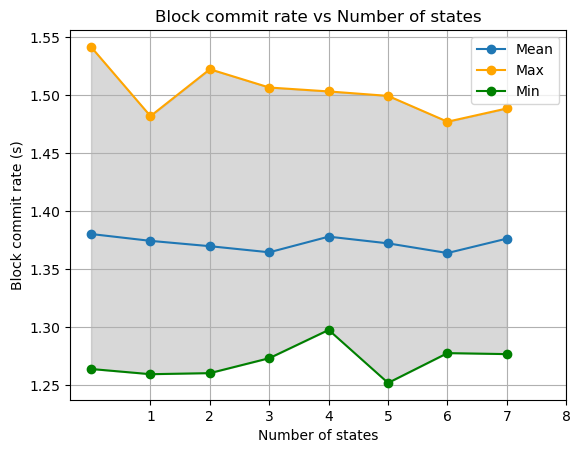

In [21]:
# plotting inv_throughput

plt.plot(mean_times.keys(), mean_times.values(), marker='o')
plt.plot(max_times.keys(), max_times.values(), marker='o', color='orange')
plt.plot(min_times.keys(), min_times.values(), marker='o', color='green')
plt.fill_between(mean_times.keys(), min_times.values(), max_times.values(), color='gray', alpha=0.3)
plt.legend(["Mean", "Max", "Min"])

plt.xlabel("Number of states")
plt.ylabel("Block commit rate (s)")
plt.title("Block commit rate vs Number of states")
plt.xticks(range(1, len(mean_times) + 1), range(1, len(mean_times) + 1))
plt.grid()
plt.savefig(f"{img_folder}/block_commit_rate.png")
plt.show()

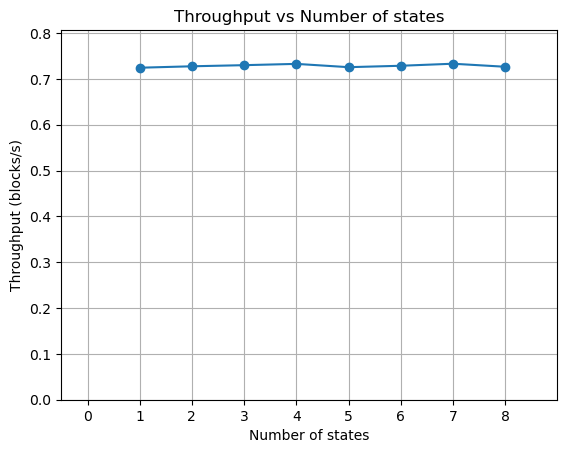

In [22]:
throughput = dict()
for n_states in mean_times:
    throughput[int(n_states)] = 1 / mean_times[n_states]
    
plt.plot(throughput.keys(), throughput.values(), marker='o')

plt.xlabel("Number of states")
plt.ylabel("Throughput (blocks/s)")
plt.title("Throughput vs Number of states")
plt.xticks(range(0, len(throughput) + 1), range(0, len(throughput) + 1))
plt.xlim(-0.5, len(throughput) + 1)
plt.ylim(0, max(throughput.values()) * 1.1)
plt.grid()
plt.savefig(f"{output_folder}/throughput_vs_nstates.png")
plt.show()